CODE BLOCK: 1

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_7")

In [3]:
from utils import plot_samples, plot_accuracy_metrics
from models import *

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


CODE BLOCK: 2

In [5]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 3

In [6]:
# Train data transformations
train_transforms = transforms.Compose([
    # transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # transforms.Resize((28, 28)),
    # transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [7]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
# train_data = datasets.MNIST('../data', train=True, download=True)
# test_data = datasets.MNIST('../data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 151296088.55it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 18434894.81it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 220940879.07it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7341244.23it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [8]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

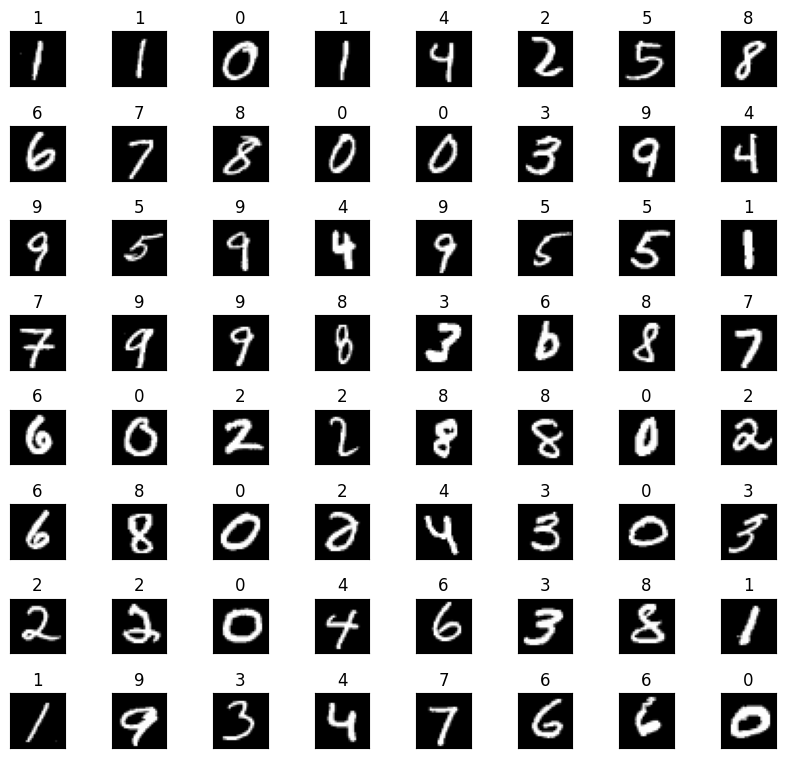

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples(batch_data,batch_label)

In [10]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model_3().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,320
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             136
           Dropout-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,168
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
           Conv2d-13             [-1, 16, 8, 8]           2,320
             ReLU-14             [-1, 1

CODE BLOCK: 8

In [11]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [12]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=1.0247 Batch_id=117 Accuracy=48.34: 100%|██████████| 118/118 [00:15<00:00,  7.64it/s]


Test set: Average loss: 1.0493, Accuracy: 7574/10000 (75.74%)

Epoch 2


Train: Loss=0.4548 Batch_id=117 Accuracy=86.78: 100%|██████████| 118/118 [00:17<00:00,  6.79it/s]


Test set: Average loss: 0.4146, Accuracy: 9407/10000 (94.07%)

Epoch 3


Train: Loss=0.2225 Batch_id=117 Accuracy=94.70: 100%|██████████| 118/118 [00:18<00:00,  6.55it/s]


Test set: Average loss: 0.2003, Accuracy: 9634/10000 (96.34%)

Epoch 4


Train: Loss=0.1692 Batch_id=117 Accuracy=96.28: 100%|██████████| 118/118 [00:14<00:00,  8.00it/s]


Test set: Average loss: 0.1326, Accuracy: 9741/10000 (97.41%)

Epoch 5


Train: Loss=0.1258 Batch_id=117 Accuracy=96.89: 100%|██████████| 118/118 [00:14<00:00,  7.99it/s]


Test set: Average loss: 0.1028, Accuracy: 9774/10000 (97.74%)

Epoch 6


Train: Loss=0.1058 Batch_id=117 Accuracy=97.37: 100%|██████████| 118/118 [00:15<00:00,  7.83it/s]


Test set: Average loss: 0.1139, Accuracy: 9714/10000 (97.14%)

Epoch 7


Train: Loss=0.1411 Batch_id=117 Accuracy=97.68: 100%|██████████| 118/118 [00:14<00:00,  7.95it/s]


Test set: Average loss: 0.0862, Accuracy: 9795/10000 (97.95%)

Epoch 8


Train: Loss=0.0556 Batch_id=117 Accuracy=97.86: 100%|██████████| 118/118 [00:15<00:00,  7.84it/s]


Test set: Average loss: 0.0697, Accuracy: 9826/10000 (98.26%)

Epoch 9


Train: Loss=0.0951 Batch_id=117 Accuracy=97.95: 100%|██████████| 118/118 [00:14<00:00,  7.92it/s]


Test set: Average loss: 0.0671, Accuracy: 9830/10000 (98.30%)

Epoch 10


Train: Loss=0.0433 Batch_id=117 Accuracy=98.16: 100%|██████████| 118/118 [00:14<00:00,  7.92it/s]


Test set: Average loss: 0.0700, Accuracy: 9808/10000 (98.08%)

Epoch 11


Train: Loss=0.0574 Batch_id=117 Accuracy=98.27: 100%|██████████| 118/118 [00:14<00:00,  7.98it/s]


Test set: Average loss: 0.0562, Accuracy: 9848/10000 (98.48%)

Epoch 12


Train: Loss=0.0279 Batch_id=117 Accuracy=98.37: 100%|██████████| 118/118 [00:15<00:00,  7.71it/s]


Test set: Average loss: 0.0519, Accuracy: 9851/10000 (98.51%)

Epoch 13


Train: Loss=0.0658 Batch_id=117 Accuracy=98.42: 100%|██████████| 118/118 [00:14<00:00,  7.94it/s]


Test set: Average loss: 0.0580, Accuracy: 9845/10000 (98.45%)

Epoch 14


Train: Loss=0.0555 Batch_id=117 Accuracy=98.50: 100%|██████████| 118/118 [00:15<00:00,  7.86it/s]


Test set: Average loss: 0.0531, Accuracy: 9854/10000 (98.54%)

Epoch 15


Train: Loss=0.0496 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:15<00:00,  7.82it/s]


Test set: Average loss: 0.0477, Accuracy: 9866/10000 (98.66%)



CODE BLOCK: 11

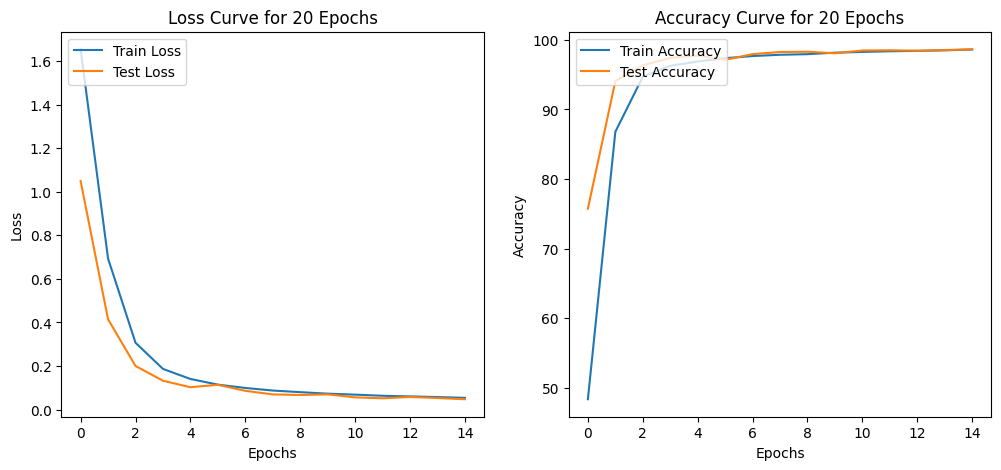

In [14]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc)